# calculates the seasonal anomalies and the seasonal tercile categories from the gridded VCSN monthly files, using the NZ territorial authorities shapefile

The shapefiles were downloaded from: 
    
[https://koordinates.com/layer/4241-nz-territorial-authorities-2012-yearly-pattern/](https://koordinates.com/layer/4241-nz-territorial-authorities-2012-yearly-pattern/)

In [1]:
# Paramaters 

# var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean_N'
# var_name = 'SoilM'
# var_name = 'Wind'
var_name = 'Rad'

in ['Agent', 'Lat', 'Longt', 'Date', 'MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N']

In [2]:
import os
import sys
import pathlib

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import proplot as plot

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from itertools import product

In [4]:
import salem
import geopandas as gpd

In [5]:
import xarray as xr

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [6]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [7]:
var_name

'Rad'

In [8]:
big_var = var_name.split('_')[0].upper()

In [9]:
HOME = pathlib.Path.home()

In [10]:
dpath = HOME / 'operational/VCSN/data/NC/MONTHLY/' / var_name.upper()

In [11]:
var_name.upper()

'RAD'

In [12]:
dset = salem.open_xr_dataset(dpath / f'VCSN_gridded_{var_name}_1979-01_2019-12.nc') 

In [13]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    Rad      (time, lat, lon) float64 ...
    agent    (lat, lon) float32 ...
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

### calculates the seasonal average (or sum if Rain_bc is the variable )

In [14]:
if var_name == 'Rain_bc': 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

In [15]:
dset = dset.isel(time=slice(2,None))

In [16]:
nz_regions = gpd.read_file(HOME / 'research' / 'Smart_Ideas' / 'data' / 'shapefiles' / 'NZ_districts' / 'nz-territorial-authorities-2012-yearly-pattern.shp') 

In [17]:
nz_regions.head()

,TA12,NAME,geometry
0,001,Far North District,"MULTIPOLYGON (((173.16053 -35.31148, 173.16045..."
1,002,Whangarei District,"MULTIPOLYGON (((174.69731 -35.99219, 174.69782..."
2,003,Kaipara District,"MULTIPOLYGON (((174.27348 -36.28929, 174.27354..."
3,011,Thames-Coromandel District,"MULTIPOLYGON (((175.90054 -37.22147, 175.90049..."
4,012,Hauraki District,"MULTIPOLYGON (((175.53358 -37.16871, 175.53400..."


In [18]:
nz_regions.tail()

,TA12,NAME,geometry
62,074,Gore District,"POLYGON ((168.99659 -45.79218, 168.99744 -45.7..."
63,075,Invercargill City,"MULTIPOLYGON (((168.41352 -46.65071, 168.41355..."
64,076,Auckland,"POLYGON ((175.08383 -35.69983, 175.09081 -35.7..."
65,060,Christchurch City,"POLYGON ((172.70029 -43.39091, 172.70038 -43.3..."
66,999,Area Outside Territorial Authority,"MULTIPOLYGON (((176.02181 -36.37127, 176.02408..."


### remove the area outside Territorial Authority

In [19]:
nz_regions = nz_regions.iloc[:-1,:]

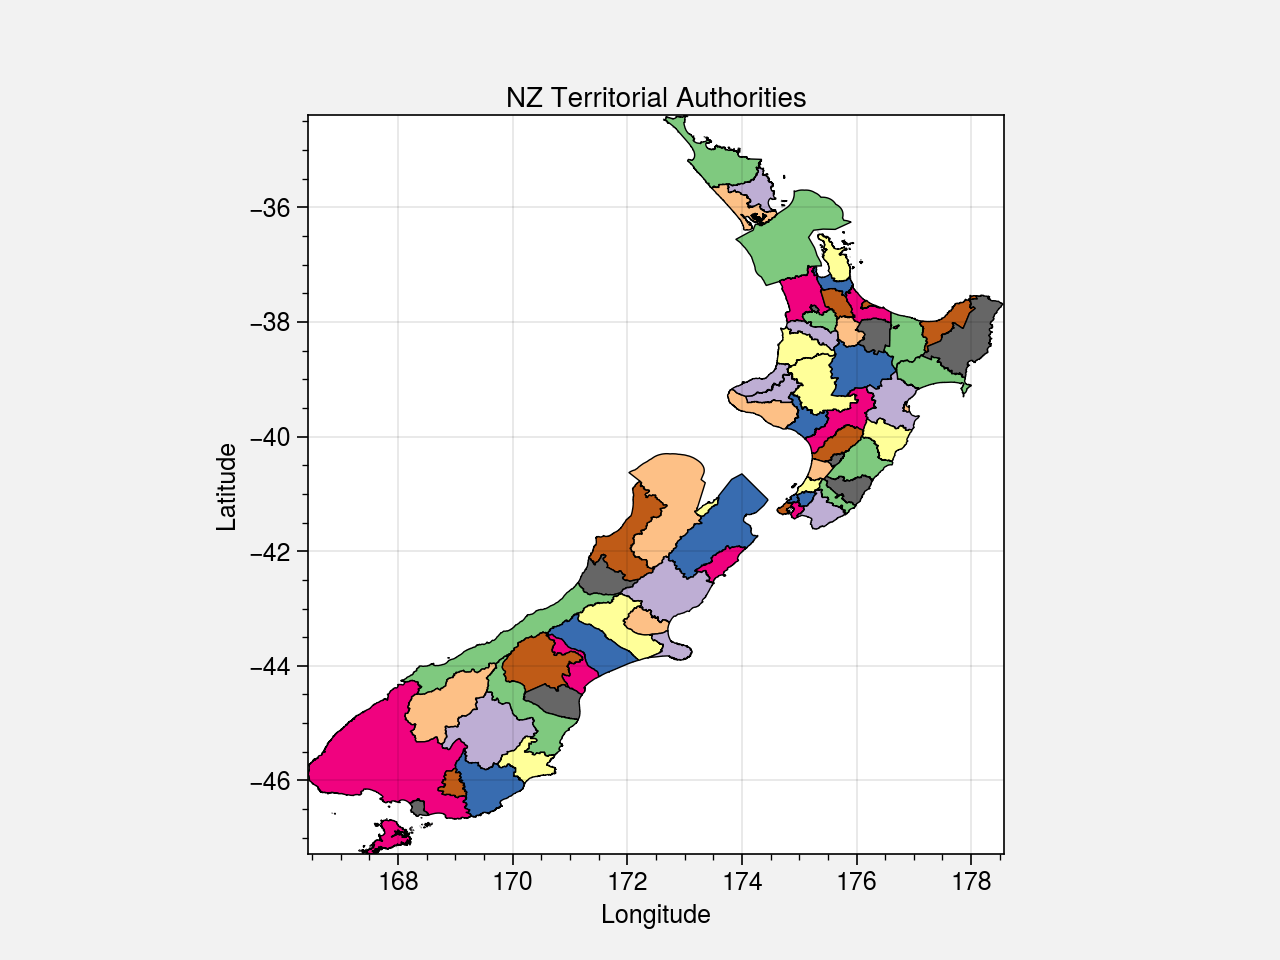

In [20]:
f, ax = plt.subplots()
nz_regions.plot(cmap=plt.cm.Accent, figsize=(10,15), lw=2, edgecolor="black", linewidth=.5, ax=ax)
ax.set_title('NZ Territorial Authorities')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
f.savefig(HOME / 'research' / 'Smart_Ideas' / 'figures' / 'NZ_TA_loc.png', dpi=200, bbox_inches='tight')

In [21]:
nz_regions.NAME.values

array(['Far North District', 'Whangarei District', 'Kaipara District',
       'Thames-Coromandel District', 'Hauraki District',
       'Waikato District', 'Matamata-Piako District', 'Hamilton City',
       'Waipa District', 'Otorohanga District', 'South Waikato District',
       'Waitomo District', 'Taupo District',
       'Western Bay of Plenty District', 'Tauranga City',
       'Rotorua District', 'Whakatane District', 'Stratford District',
       'South Taranaki District', 'Ruapehu District', 'Wanganui District',
       'Rangitikei District', 'Manawatu District',
       'Palmerston North City', 'Tararua District',
       'New Plymouth District', 'Horowhenua District',
       'Kapiti Coast District', 'Porirua City', 'Kawerau District',
       'Opotiki District', 'Gisborne District', 'Wairoa District',
       'Hastings District', 'Napier City', "Central Hawke's Bay District",
       'Upper Hutt City', 'Lower Hutt City', 'Wellington City',
       'Masterton District', 'Carterton Distri

### sanitize the names of the territorial authorities 

In [22]:
nz_regions.loc[:,'NAME'] = nz_regions.loc[:,'NAME'].str.replace(' District','').str.replace("'",'').str.replace(' ','_')

In [23]:
nz_regions.NAME.values

array(['Far_North', 'Whangarei', 'Kaipara', 'Thames-Coromandel',
       'Hauraki', 'Waikato', 'Matamata-Piako', 'Hamilton_City', 'Waipa',
       'Otorohanga', 'South_Waikato', 'Waitomo', 'Taupo',
       'Western_Bay_of_Plenty', 'Tauranga_City', 'Rotorua', 'Whakatane',
       'Stratford', 'South_Taranaki', 'Ruapehu', 'Wanganui', 'Rangitikei',
       'Manawatu', 'Palmerston_North_City', 'Tararua', 'New_Plymouth',
       'Horowhenua', 'Kapiti_Coast', 'Porirua_City', 'Kawerau', 'Opotiki',
       'Gisborne', 'Wairoa', 'Hastings', 'Napier_City',
       'Central_Hawkes_Bay', 'Upper_Hutt_City', 'Lower_Hutt_City',
       'Wellington_City', 'Masterton', 'Carterton', 'South_Wairarapa',
       'Tasman', 'Nelson_City', 'Marlborough', 'Kaikoura', 'Buller',
       'Grey', 'Westland', 'Hurunui', 'Waimakariri', 'Selwyn',
       'Ashburton', 'Timaru', 'Mackenzie', 'Waimate', 'Waitaki',
       'Central_Otago', 'Queenstown-Lakes', 'Dunedin_City', 'Clutha',
       'Southland', 'Gore', 'Invercargill_City', 

### creates the folder for the outputs if not already there 

In [24]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'NZ_territorial_authorities'

In [25]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [26]:
num_quantiles = 3

In [27]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [28]:
quant_values = quant_values[1:-1]

In [29]:
quant_values

array([0.33333333, 0.66666667])

In [30]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [31]:
col_labs

['Q33', 'Q66']

In [32]:
quantiles_dict = {}

for i, region_name in enumerate(nz_regions.NAME): 
    
    shape = nz_regions.query(f"NAME == '{region_name}'")
    
    region = dset.salem.subset(shape=shape)
    
    # here test whether there are more than one grid point in the 
    # resulting dataset, if yes then extract the ROI
    
    if ((region.dims['lat'] > 1) & (region.dims['lon'] > 1)):

        region = region.salem.roi(shape=shape, all_touched=True)
        
    agents = region.agent.stack(z=('lat', 'lon')).dropna(dim='z')
    
    n_agents = len(agents)
        
    ts = region.mean(dim=['lat','lon'])
    
    ts_df = ts[var_name].to_dataframe()
            
    ts_series = ts_df.loc[:,var_name]
    
    ts_series_cat = []
    
    quantiles_list = []
    
    for month in range(1, 13):
        
        ts_series_m = ts_series[ts_series.index.month == month]
        
        clim = ts_series_m.loc['1981':'2010']
        
        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]
        
        quantiles_list.append(quantiles.copy())
        
        quantiles.insert(0, -np.inf)
        
        quantiles.append(np.inf)
        
        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))
        
        ts_series_cat.append(ts_series_m_cats)
        
        del(quantiles)
     
    quantiles_dict[region_name]  = np.array(quantiles_list)
    
    ts_series_cat = pd.concat(ts_series_cat, axis=0)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    ts_df.loc[:,'n_agents'] = n_agents
    
    ts_df.loc[:,f'cat_{num_quantiles}'] = ts_series_cat
    
    ts_df.loc[:,'anomalies'] = ts_df.loc[:,var_name].groupby(ts_df.index.month).apply(demean)
    
    opath = opath_root / big_var / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    ts_df.to_csv(opath / f'TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms.csv')
    
    #descriptive statistics per quantile category 
    
    ts_df.groupby(ts_df.loc[:,f'cat_{num_quantiles}']).describe().to_csv(opath / f'descriptive_stats_{region_name}__{big_var}_{num_quantiles}.csv')
    
    print(f"region {region_name} processed for variable {big_var}")
    

region Far_North processed for variable RAD
region Whangarei processed for variable RAD
region Kaipara processed for variable RAD
region Thames-Coromandel processed for variable RAD
region Hauraki processed for variable RAD
region Waikato processed for variable RAD
region Matamata-Piako processed for variable RAD
region Hamilton_City processed for variable RAD
region Waipa processed for variable RAD
region Otorohanga processed for variable RAD
region South_Waikato processed for variable RAD
region Waitomo processed for variable RAD
region Taupo processed for variable RAD
region Western_Bay_of_Plenty processed for variable RAD
region Tauranga_City processed for variable RAD
region Rotorua processed for variable RAD
region Whakatane processed for variable RAD
region Stratford processed for variable RAD
region South_Taranaki processed for variable RAD
region Ruapehu processed for variable RAD
region Wanganui processed for variable RAD
region Rangitikei processed for variable RAD
region Ma

### saves the climatological terciles calculated from the VCSN regional aggregates

In [33]:
quantiles_list = []
for region_name in nz_regions.NAME: 
    df = pd.DataFrame(quantiles_dict[region_name])
    df.index = range(1, 13)
    df.index.name = 'season'
    df.columns = pd.MultiIndex.from_product([[region_name],col_labs])
    quantiles_list.append(df)

In [34]:
quantiles_df = pd.concat(quantiles_list, axis=1)

In [35]:
quantiles_df

Far_North             Whangarei               Kaipara             \
              Q33        Q66        Q33        Q66        Q33        Q66   
season                                                                     
1       20.519761  21.142662  20.460350  21.471264  20.521475  21.681567   
2       20.110617  20.721105  20.138727  20.917647  20.351172  21.087937   
3       18.305378  18.935801  18.260208  19.094506  18.472003  19.147771   
4       15.085015  15.686684  15.007090  15.747432  14.977970  15.857406   
5       11.613641  11.834904  11.331272  12.029686  11.231400  12.092357   
6        8.874058   9.124477   8.659582   9.010024   8.578384   9.004569   
7        7.657338   7.954284   7.388428   7.867460   7.255982   7.791165   
8        8.094044   8.506086   7.883187   8.442196   7.797009   8.357805   
9       10.414929  10.789989  10.128839  10.714038  10.085013  10.573855   
10      13.363294  13.989268  13.028680  13.793435  12.870139  13.649485   
11      16.407696  17.045054  16.375410  17.064523  16.402002  17.146031   
12      18.793710  19.603421  19.003887  19.889408  18.996934  19.813535   

       Thames-Coromandel               Hauraki             ...  Southland  \
                     Q33        Q66        Q33        Q66  ...        Q33   
season                                                     ...              
1              20.301005  21.595679  20.483717  21.324518  ...  19.664198   
2              20.063338  21.285786  20.279063  20.984384  ...  19.311080   
3              18.291206  19.199943  18.484982  19.048958  ...  16.605109   
4              14.836285  15.654151  14.788543  15.704818  ...  12.622976   
5              11.182457  12.055913  11.312413  11.685284  ...   8.400513   
6               8.310441   8.950902   8.217495   8.697834  ...   5.454732   
7               6.805582   7.407984   6.874048   7.279657  ...   4.137281   
8               7.372516   7.919811   7.234783   7.843194  ...   4.842860   
9               9.533800  10.248671   9.420406  10.015850  ...   7.107918   
10             12.943042  13.429575  12.625769  13.190887  ...  10.836601   
11             16.168955  16.822137  15.993578  16.722854  ...  14.819341   
12             18.901751  19.719786  18.750382  19.532784  ...  18.168846   

                        Gore            Invercargill_City             \
              Q66        Q33        Q66               Q33        Q66   
season                                                                 
1       20.466217  19.908553  20.717273         19.868776  20.547210   
2       19.935739  19.257038  19.988782         19.086920  19.702360   
3       17.101249  16.572070  17.263739         16.172726  16.659068   
4       13.061594  12.878420  13.439409         12.226238  12.458898   
5        8.818104   8.847471   9.083286          8.057938   8.367719   
6        5.642259   5.805250   5.984429          5.176362   5.411875   
7        4.316663   4.480373   4.699959          4.050845   4.227188   
8        4.997320   5.198408   5.388131          4.728517   4.977428   
9        7.466044   7.705701   7.994474          7.128879   7.462737   
10      11.130759  11.314927  11.770277         10.750542  11.192679   
11      15.419276  15.355337  16.011816         14.866272  15.594997   
12      18.640015  18.633747  19.217089         18.535499  19.004763   

         Auckland            Christchurch_City             
              Q33        Q66               Q33        Q66  
season                                                     
1       20.256165  21.845097         21.280866  22.407444  
2       20.113982  21.296532         20.409679  21.388805  
3       18.551103  19.508163         17.757943  18.566956  
4       15.065487  16.040138         13.643034  14.311450  
5       11.407900  12.284566          9.592012   9.997561  
6        8.446227   8.982111          6.448088   6.642015  
7        7.066766   7.665736          4.922414   5.213863  
8        7.728579   8.179217  

In [37]:
quantiles_df.to_csv(opath.parent / f'Climatological_quantiles_{num_quantiles}_cat_{big_var}.csv')